figure 6.5: maximization bias - q-learning vs double q-learning

running experiment with:
  episodes per run: 300
  number of independent runs: 10000

training q-learning agent...
training double q-learning agent...

saved figure to: figure_6_5_maximization_bias.png


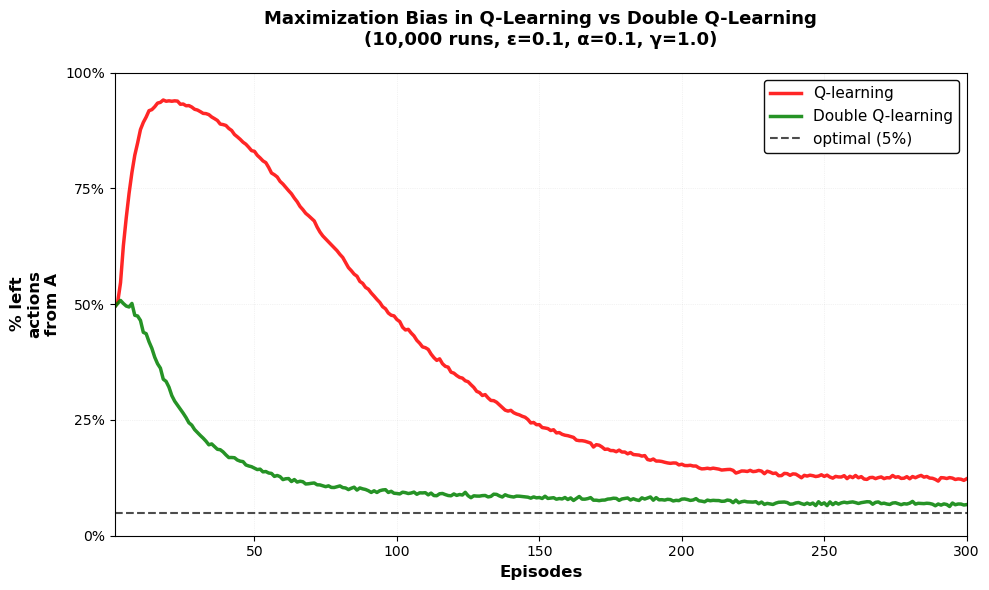


summary statistics
q-learning - final % left actions:        12.3%
double q-learning - final % left actions: 6.7%
optimal policy % left actions:            5.0%

q-learning excess left selection:          7.3%
double q-learning excess left selection:   1.7%


In [1]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Figure 6.5 Maximization Bias Q-learning and Double Q-learning 
# Comparison of Q-learning and Double Q-learning on a simple episodic MDP environment
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt

class MaxBiasEnvironment:
    """
    simple two-state episodic environment that demonstrates maximization bias.
    
    structure:
    - start in state A with two actions: left and right
    - left action: transition to state B with reward 0
    - from B: many actions all terminate with reward ~ N(-0.1, 1)
    - right action: immediate termination with reward 0
    
    the optimal policy is to take RIGHT (avoiding the noisy negative rewards).
    but q-learning with maximization bias will overestimate the value of
    going LEFT because of noise in the B rewards.
    """
    
    def __init__(self, seed=None):
        self.rng = np.random.RandomState(seed)
        self.current_state = 'A'
        self.is_terminal = False
        
    def reset(self):
        """start a new episode in state A"""
        self.current_state = 'A'
        self.is_terminal = False
        return 'A'
    
    def step(self, action):
        """
        execute one step in the environment
        
        returns: (next_state, reward, is_terminal)
        """
        if self.is_terminal:
            raise RuntimeError("episode already terminated")
        
        if self.current_state == 'A':
            if action == 0:  # left action
                # transition to state B with zero immediate reward
                self.current_state = 'B'
                return ('B', 0.0, False)
            else:  # right action (action == 1)
                # immediate termination with zero reward (optimal choice)
                self.is_terminal = True
                return (None, 0.0, True)
        
        elif self.current_state == 'B':
            # any action in B terminates
            # reward drawn from N(-0.1, 1.0) - typically negative!
            reward = self.rng.normal(loc=-0.1, scale=1.0)
            self.is_terminal = True
            return (None, reward, True)
    
    def get_num_states(self):
        """return total number of non-terminal states"""
        return 2
    
    def get_num_actions(self):
        """return number of actions available in state A"""
        return 2


# ============================================================================
# ALGORITHM: q-learning (with maximization bias)
# ============================================================================

class QLearningAgent:
    """
    standard q-learning with epsilon-greedy exploration.
    
    key equation: Q(s, a) += alpha * [r + gamma * max_a' Q(s', a') - Q(s, a)]
    
    problem: uses the SAME estimate for both:
    1) selecting which action maximizes value in next state
    2) estimating that maximum value
    
    in state B with many actions, the max of noisy estimates is biased upward
    even though true max is negative. this causes Q(A, left) to be overestimated.
    """
    
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=1.0, epsilon=0.1):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.rng = np.random.RandomState()
        
        # q-values indexed by state name ('A' or 'B')
        # state A has 2 actions, state B has 10 possible actions
        self.q_values = {
            'A': np.zeros(num_actions),      # left (0) and right (1)
            'B': np.zeros(10)                 # 10 actions in state B
        }
    
    def set_seed(self, seed):
        """set random seed for reproducibility"""
        self.rng = np.random.RandomState(seed)
    
    def get_action(self, state):
        """
        epsilon-greedy action selection
        
        with probability epsilon: select random action
        otherwise: select action with highest q-value
        """
        if self.rng.rand() < self.epsilon:
            # explore: random action
            if state == 'A':
                return self.rng.randint(0, self.num_actions)
            else:  # state B
                return self.rng.randint(0, 10)
        else:
            # exploit: greedy action (highest q-value)
            if state == 'A':
                # break ties randomly
                q_vals = self.q_values['A']
                max_q = np.max(q_vals)
                best_actions = np.where(q_vals == max_q)[0]
                return self.rng.choice(best_actions)
            else:  # state B
                q_vals = self.q_values['B']
                max_q = np.max(q_vals)
                best_actions = np.where(q_vals == max_q)[0]
                return self.rng.choice(best_actions)
    
    def update(self, state, action, reward, next_state, next_action=None):
        """
        q-learning update rule
        
        uses max of next_state values as bootstrap target
        this is where maximization bias occurs: the max of noisy estimates
        in state B tends to be positive even though true values are ~-0.1
        """
        if next_state is None:
            # terminal state: bootstrap value is just the reward
            target = reward
        else:
            # non-terminal: bootstrap using max q-value in next state
            if next_state == 'A':
                max_next_q = np.max(self.q_values['A'])
            else:  # next_state == 'B'
                max_next_q = np.max(self.q_values['B'])
            
            target = reward + self.gamma * max_next_q
        
        # temporal difference error
        td_error = target - self.q_values[state][action]
        
        # update q-value
        self.q_values[state][action] += self.alpha * td_error
    
    def get_greedy_action_from_a(self):
        """
        return greedy action from state A (0=left, 1=right)
        based on current q-value estimates
        """
        q_left = self.q_values['A'][0]
        q_right = self.q_values['A'][1]
        
        if q_left > q_right:
            return 0  # choose left
        elif q_right > q_left:
            return 1  # choose right
        else:
            # tied: random choice
            return self.rng.choice([0, 1])


# ============================================================================
# ALGORITHM: double q-learning (corrects maximization bias)
# ============================================================================

class DoubleQLearningAgent:
    """
    double q-learning algorithm that addresses maximization bias.
    
    key idea: maintain TWO independent q-value estimates (Q1 and Q2).
    on each step, randomly update one using the other.
    
    update for Q1: Q1(s,a) += alpha * [r + gamma * Q2(argmax_a' Q1(s',a')) - Q1(s,a)]
    update for Q2: Q2(s,a) += alpha * [r + gamma * Q1(argmax_a' Q2(s',a')) - Q2(s,a)]
    """
    
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=1.0, epsilon=0.1):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.rng = np.random.RandomState()
        
        # two independent q-value estimates
        self.q_values_1 = {
            'A': np.zeros(num_actions),
            'B': np.zeros(10)
        }
        self.q_values_2 = {
            'A': np.zeros(num_actions),
            'B': np.zeros(10)
        }
    
    def set_seed(self, seed):
        """set random seed for reproducibility"""
        self.rng = np.random.RandomState(seed)
    
    def get_action(self, state):
        """
        epsilon-greedy using average of both q-estimates
        
        averaging both estimates for action selection provides more
        stable behavior than using a single estimate
        """
        if self.rng.rand() < self.epsilon:
            # explore: random action
            if state == 'A':
                return self.rng.randint(0, self.num_actions)
            else:  # state B
                return self.rng.randint(0, 10)
        else:
            # exploit: greedy based on average of both estimates
            if state == 'A':
                avg_q = (self.q_values_1['A'] + self.q_values_2['A']) / 2.0
                max_q = np.max(avg_q)
                best_actions = np.where(avg_q == max_q)[0]
                return self.rng.choice(best_actions)
            else:  # state B
                avg_q = (self.q_values_1['B'] + self.q_values_2['B']) / 2.0
                max_q = np.max(avg_q)
                best_actions = np.where(avg_q == max_q)[0]
                return self.rng.choice(best_actions)
    
    def update(self, state, action, reward, next_state, next_action=None):
        """
        double q-learning update
        
        randomly choose to update either Q1 or Q2 on this step
        this decoupling eliminates maximization bias
        """
        # randomly decide which estimate to update
        update_q1 = self.rng.rand() < 0.5
        
        if update_q1:
            # update Q1 using Q2 for value estimation
            if next_state is None:
                target = reward
            else:
                # select best action in next_state using Q1
                if next_state == 'A':
                    best_action = np.argmax(self.q_values_1['A'])
                    # estimate its value using Q2
                    bootstrap_value = self.q_values_2['A'][best_action]
                else:  # next_state == 'B'
                    best_action = np.argmax(self.q_values_1['B'])
                    bootstrap_value = self.q_values_2['B'][best_action]
                
                target = reward + self.gamma * bootstrap_value
            
            td_error = target - self.q_values_1[state][action]
            self.q_values_1[state][action] += self.alpha * td_error
        else:
            # update Q2 using Q1 for value estimation
            if next_state is None:
                target = reward
            else:
                # select best action in next_state using Q2
                if next_state == 'A':
                    best_action = np.argmax(self.q_values_2['A'])
                    # estimate its value using Q1
                    bootstrap_value = self.q_values_1['A'][best_action]
                else:  # next_state == 'B'
                    best_action = np.argmax(self.q_values_2['B'])
                    bootstrap_value = self.q_values_1['B'][best_action]
                
                target = reward + self.gamma * bootstrap_value
            
            td_error = target - self.q_values_2[state][action]
            self.q_values_2[state][action] += self.alpha * td_error
    
    def get_greedy_action_from_a(self):
        """
        return greedy action from state A (0=left, 1=right)
        based on average of both q-value estimates
        """
        avg_q_left = (self.q_values_1['A'][0] + self.q_values_2['A'][0]) / 2.0
        avg_q_right = (self.q_values_1['A'][1] + self.q_values_2['A'][1]) / 2.0
        
        if avg_q_left > avg_q_right:
            return 0  # choose left
        elif avg_q_right > avg_q_left:
            return 1  # choose right
        else:
            # tied: random choice
            return self.rng.choice([0, 1])

# ============================================================================
# TRAINING LOOP
# ============================================================================

def run_episode(agent, env):
    """
    run one complete episode with given agent and environment
        """
    state = env.reset()
    action_in_a = None
    
    while not env.is_terminal:
        action = agent.get_action(state)
        
        # store the action taken from state A for later analysis
        if state == 'A':
            action_in_a = action
        
        next_state, reward, is_terminal = env.step(action)
        
        # agent learns from this experience
        agent.update(state, action, reward, next_state)
        
        state = next_state
    
    return action_in_a


def run_experiment(num_episodes, num_runs, algorithm_type='qlearning'):
    """
    run complete experiment comparing algorithms
    
    tracks which action is taken from state A in each episode.
    need to track LEFT action percentage (action 0).
    """
    left_action_count = np.zeros((num_runs, num_episodes))
    
    for run_idx in range(num_runs):
        # create fresh environment and agent for each run
        env = MaxBiasEnvironment(seed=run_idx)
        
        if algorithm_type == 'qlearning':
            agent = QLearningAgent(
                num_states=2,
                num_actions=2,
                alpha=0.1,
                gamma=1.0,
                epsilon=0.1
            )
        else:  # double q-learning
            agent = DoubleQLearningAgent(
                num_states=2,
                num_actions=2,
                alpha=0.1,
                gamma=1.0,
                epsilon=0.1
            )
        
        agent.set_seed(run_idx)
        
        # run episodes
        for episode_idx in range(num_episodes):
            action_in_a = run_episode(agent, env)
            # track if action was LEFT (action 0)
            left_action_count[run_idx, episode_idx] = (action_in_a == 0)
    
    return left_action_count


# ============================================================================
# VISUALIZATION
# ============================================================================

def create_figure_6_5():
    """
    recreate figure 6.5 from the textbook
    """
    print("=" * 70)
    print("figure 6.5: maximization bias - q-learning vs double q-learning")
    print("=" * 70)
    
    # experimental parameters
    num_episodes = 300
    num_runs = 10000
    #commnet out when submitting
    print(f"\nrunning experiment with:")
    print(f"  episodes per run: {num_episodes}")
    print(f"  number of independent runs: {num_runs}")
    
    # run both algorithms
    print("\ntraining q-learning agent...")
    qlearn_results = run_experiment(num_episodes, num_runs, algorithm_type='qlearning')
    
    print("training double q-learning agent...")
    double_qlearn_results = run_experiment(num_episodes, num_runs, algorithm_type='doubleqlearning')
    
    # compute percentage of left actions averaged over runs
    qlearn_left_pct = np.mean(qlearn_results, axis=0) * 100
    double_qlearn_left_pct = np.mean(double_qlearn_results, axis=0) * 100
    
    # create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # plot the curves
    episodes = np.arange(1, num_episodes + 1)
    
    ax.plot(episodes, qlearn_left_pct, 'r-', linewidth=2.5, label='Q-learning', alpha=0.85)
    ax.plot(episodes, double_qlearn_left_pct, 'g-', linewidth=2.5, label='Double Q-learning', alpha=0.85)
    
    # add horizontal line for optimal policy (5% due to epsilon=0.1)
    ax.axhline(y=5, color='k', linestyle='--', linewidth=1.5, alpha=0.7, label='optimal (5%)')
    
    # formatting
    ax.set_xlabel('Episodes', fontsize=12, fontweight='bold')
    ax.set_ylabel('% left\nactions\nfrom A', fontsize=12, fontweight='bold')
    ax.set_xlim([1, num_episodes])
    ax.set_ylim([0, 100])
    
    # set y-axis ticks manually to avoid warning
    y_ticks_pos = [0, 25, 50, 75, 100]
    ax.set_yticks(y_ticks_pos)
    ax.set_yticklabels([f'{y}%' for y in y_ticks_pos])
    
    # grid
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    
    # legend
    ax.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor='black')
    
    # title
    ax.set_title('Maximization Bias in Q-Learning vs Double Q-Learning\n' +
                 '(10,000 runs, ε=0.1, α=0.1, γ=1.0)',
                 fontsize=13, fontweight='bold', pad=20)
    
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    plt.tight_layout()
    plt.savefig('figure_6_5_maximization_bias.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print("\nsaved figure to: figure_6_5_maximization_bias.png")
    plt.show()
    
    # print summary statistics
    print("\n" + "=" * 70)
    
	#for testing only, comment out when submitting
    print("summary statistics")
    print("=" * 70)
    print(f"q-learning - final % left actions:        {qlearn_left_pct[-1]:.1f}%")
    print(f"double q-learning - final % left actions: {double_qlearn_left_pct[-1]:.1f}%")
    print(f"optimal policy % left actions:            5.0%")
    print(f"\nq-learning excess left selection:          {qlearn_left_pct[-1] - 5:.1f}%")
    print(f"double q-learning excess left selection:   {double_qlearn_left_pct[-1] - 5:.1f}%")


# ============================================================================
# MAIN
# ============================================================================

if __name__ == "__main__":
    create_figure_6_5()